In [217]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import  csv
import os

In [246]:
# rect [x1, x2, y1, y2]
def area(rect):
    return np.absolute(rect[0] - rect[1]) * np.absolute(rect[2] - rect[3])

# points (n, 2)
def point_in_rect(rect, points):
    x, y = points[..., 0], points[..., 1]  # (n)
    return ((((rect[0] <= x) & (x <= rect[1])) | ((rect[1] <= x) & (x <= rect[0]))) & (((rect[2] <= y) & (y <= rect[3])) | ((rect[3] <= y) & (y <= rect[2]))))

def show_rect(rects=[], points=[]):
    _, ax = plt.subplots()
    for point in points:
        ax.scatter(point[:, 0], point[:, 1])
    for rect in rects:
        box = plt.Rectangle((rect[0], rect[2]), rect[1] - rect[0], rect[3] - rect[2], fill=False, edgecolor = 'red', linewidth=1)
        ax.add_patch(box)
    ax.set_aspect(1)
    plt.show()
    
def binary_grid(points, bbox):
    l, r, b, u = bbox
    m, n = int(round((r-l)/0.01)), int(round((u-b)/0.01))
    grid = np.zeros((n, m))
    ind = point_in_rect(bbox, points)
    points = points[ind]
    idx = np.floor(points * 100) / 100
    idx[:, 0] = ((idx[:, 0] - l) / 0.01)
    idx[:, 1] = ((idx[:, 1] - b) / 0.01)
    idx = np.round(idx).astype(np.int32)
    grid[idx[:, 1], idx[:, 0]] = 1

    return 1 - grid

def find_max_area(grid):
    histogram = np.zeros_like(grid)
    histogram[0] = grid[0]
    for i in range(1, len(grid)):
        histogram[i] = grid[i] * (grid[i] + histogram[i-1])

    def largestRectangleArea(heights):
        heights = [0] + heights + [0]
        l = len(heights)
        stack = [0]
        max_area = 0
        for i in range(1, l):
            while heights[i] < heights[stack[-1]]:
                temp_area = heights[stack[-1]] * (i - stack[-2] - 1)
                if temp_area > max_area:
                    max_area = temp_area
                    cur_inf = (heights[stack[-1]], stack[-2], i-1)
                stack.pop()
            stack.append(i)
        return max_area, cur_inf
    
    max_area = 0
    for i in range(len(histogram)):
        temp_area, (h, start, end) = largestRectangleArea(histogram[i].tolist())
        if temp_area > max_area:
            max_area = temp_area
            cur_inf = (i+1-h, i+1, start, end)  # [up, bottom, start, end]    bottom, end 取不到
    
    return max_area, cur_inf
    
def convert_rect(cur_inf, lb_corner):
    up, bottom, start, end = cur_inf
    l, b = lb_corner
    l_rst = np.round(l + 0.01*start, 2)
    r_rst = np.round(l + 0.01*end, 2)
    u_rst = np.round(b + 0.01*bottom, 2)
    b_rst = np.round(b + 0.01*up, 2)

    return [l_rst, r_rst, b_rst, u_rst]

def find_connected_regions(grid):
    connected_regions = []
    rst_final = []
    m, n = grid.shape
    seen = set()

    def dfs(root):
        i, j = root
        seen.add((i, j))
        stack = [(i, j)]
        rst = []
        while stack:
            i, j = stack.pop()
            rst.append([i, j])
            if i-1 >= 0 and grid[i-1][j] == 0 and (i-1, j) not in seen:
                stack.append((i-1, j))
                seen.add((i-1, j))
            if i+1 <= m-1 and grid[i+1][j] == 0 and (i+1, j) not in seen:
                stack.append((i+1, j))
                seen.add((i+1, j))
            if j-1 >= 0 and grid[i][j-1] == 0 and (i, j-1) not in seen:
                stack.append((i, j-1))
                seen.add((i, j-1))
            if j+1 <= n-1 and grid[i][j+1] == 0 and (i, j+1) not in seen:
                stack.append((i, j+1))
                seen.add((i, j+1))
        return rst
    
    for i in range(m):
        for j in range(n):
            if grid[i][j] == 0 and (i, j) not in seen:
                connected_regions.append(dfs((i, j)))
    for region in connected_regions:
        rst_final.append(np.array(region))
    return rst_final

def clustering(regions, dist):
    def _distance(region1, region2):
        return (((region1.mean(0) - region2.mean(0))**2).sum())**0.5
    new_regions = regions[:]
    rst = [new_regions.pop(0)]
    while new_regions:
        flag = False
        for i, region in enumerate(new_regions):
            if  _distance(rst[-1], region) < dist:
                rst[-1] = np.concatenate((rst[-1], new_regions.pop(i)), 0)
                flag = True
                break
        if not flag:
            rst.append(new_regions.pop(0))
    return rst

In [219]:
xyz_cls = []
with open('rst_subsample.xyz', 'r', encoding='utf-8') as f:
    for ann in tqdm(f.readlines()):
        ann = ann.strip('\n').split(' ')
        xyz_cls.append([float(ann[0]), float(ann[1]), float(ann[2]), int(float(ann[4]))])
xyz_cls = np.array(xyz_cls)

100%|██████████| 436424/436424 [00:01<00:00, 371758.64it/s]


In [220]:
cls_dict = {
    0: "wall",
    1: "ceil",
    2: "floor",
    3: "column",
    4: "beam",
    5: "tube",
    6: "window"
}

dir_path = 'C:\\Users\\Big squirrel\\Desktop\\bishe\\codes\\xyz_cls_2'

## 墙

In [248]:
divide = 30
# rect_angel = []
max_area = 0
wall = xyz_cls[xyz_cls[:,3] == 0][:,0:2]
for i in tqdm(np.linspace(0, 15, divide)):
    theta = -i
    rotate_matrix = np.array(
        [
            [np.cos(np.pi * theta/180), -np.sin(np.pi * theta/180)],
            [np.sin(np.pi * theta/180), np.cos(np.pi * theta/180)]
        ]
    )
    rotated_wall = (rotate_matrix @ wall.T).T
    l, b = np.floor(rotated_wall.min(0) * 100) / 100
    r, u = np.ceil(rotated_wall.max(0) * 100) / 100
    bbox = (l, r, b, u)
    grid = binary_grid(rotated_wall, bbox)
    _, cur_inf = find_max_area(grid)
    rect = convert_rect(cur_inf, (l, b))
    temp_area = area(rect)
    if temp_area > max_area:
        max_area = temp_area
        cur = [rect, rotate_matrix.copy()]
wall_bound, rotate_matrix = cur
    

100%|██████████| 30/30 [00:03<00:00,  7.89it/s]


In [249]:
cur

[[-2.13, 2.1, -1.46, 1.3],
 array([[ 0.98374484,  0.17957194],
        [-0.17957194,  0.98374484]])]

In [250]:
# 旋转所有点云，新坐标系
rotate_matrix_3d = np.eye(3)
rotate_matrix_3d[:2,:2] = rotate_matrix
xyz_cls_new = xyz_cls.copy()
xyz_cls_new[:, :3] = (rotate_matrix_3d @ xyz_cls[:, :3].T).T

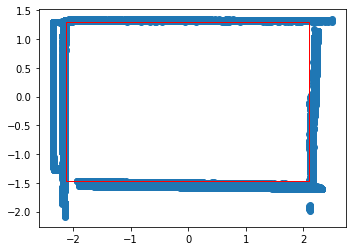

In [251]:
wall = xyz_cls_new[xyz_cls_new[:,3] == 0][:,0:2]
show_rect([wall_bound], [wall])

In [229]:
(point_in_rect(wall_bound, wall)).sum()

0

## 天花、地面

In [252]:
ceil = xyz_cls_new[xyz_cls[:,3] == 1][:,0:3]
floor = xyz_cls_new[xyz_cls[:,3] == 2][:,0:3]
ceil_bound = np.floor(ceil[:,2].min() * 100) / 100
floor_bound = np.ceil(floor[:,2].max() * 100) / 100
print("天花：", ceil_bound)
print("地面：", floor_bound)


天花： 3.84
地面： -0.27


## 梁

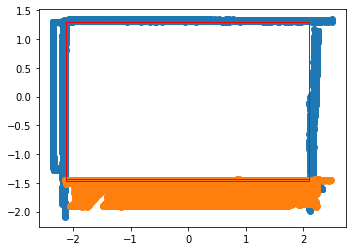

In [253]:
beam = xyz_cls_new[xyz_cls[:,3] == 4][:,0:3]
grid = binary_grid(beam, wall_bound)
_, cur_inf = find_max_area(grid)
beam_bound = convert_rect(cur_inf, (wall_bound[0], wall_bound[2]))
show_rect([wall_bound, beam_bound], [wall, beam])

In [189]:
(point_in_rect(beam_bound, beam)).sum()

0

In [255]:
beam_bound

[-2.13, 2.1, -1.44, 1.3]

In [245]:
beam_bottom_bound = np.floor(beam[:,2].min() * 100) / 100
print("梁底：", beam_bottom_bound)

梁底： 3.41


## 柱子

In [232]:
column = xyz_cls_new[xyz_cls[:,3] == 3][:,0:3]
grid = binary_grid(column, wall_bound)
# 求连通域
connected_regions = find_connected_regions(grid)
# 聚类
columns = clustering(connected_regions, 30)
# 每个簇的最小外接矩形
column_bounds = []
for col in columns:
    up, start = col.min(0)
    bottom, end = col.max(0) + 1
    column_bound = convert_rect((up, bottom, start, end), (wall_bound[0], wall_bound[2]))
    column_bounds.append(column_bound)

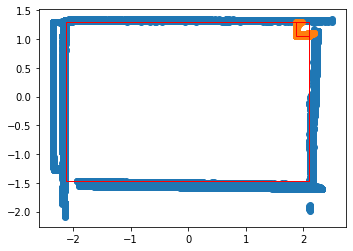

In [254]:
bounds = [wall_bound]
bounds.extend(column_bounds)
objects = [wall]
objects.append(column)
show_rect(bounds, objects)

In [257]:
bounds

[[-2.13, 2.1, -1.46, 1.3], [1.87, 2.1, 1.05, 1.3]]

## 窗户

In [243]:
filter = xyz_cls_new[xyz_cls_new[:,3] == 0][:, 0] < xyz_cls_new[xyz_cls_new[:,3] == 0][:, 0].mean()
window = xyz_cls_new[xyz_cls_new[:,3] == 0][filter][:, 1:3]

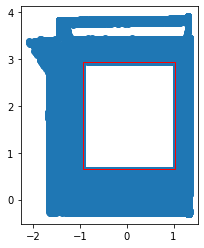

In [259]:
l, r, b, u = wall_bound[2], wall_bound[3], floor_bound, ceil_bound
grid = binary_grid(window, (l, r, b, u))
_, cur_inf = find_max_area(grid)
window_bound = convert_rect(cur_inf, (l, b))
show_rect([window_bound], [window])

In [260]:
window_bound

[-0.94, 1.04, 0.65, 2.94]

## 写入数据

In [261]:
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

for i in range(len(cls_dict)):
    data = xyz_cls_new[xyz_cls_new[:,3] == i][:,0:3] * 100
    with open(dir_path + f'\\{cls_dict[i]}.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

## 模拟退火

In [56]:
T = 1  # 初始温度
std = 1e-30  # 终止温度
a = 0.999  # 衰减率
rect = np.array([-1,1,-0.5,0.5])
bbox = [-1.5,1.5,1,-1.5]

while T > std:
    area_temp = area(rect)
    # # 新值通过扰动产生
    # rect_new = np.copy(rect)
    # idx = int(np.random.randint(0, 3, 1))
    # rect_new[idx] = rect_new[idx] + np.random.randint(-3, 3, 1) * 0.01
    # # rect_new[0::2] = rect_new[0::2] + np.random.randint(-3, 1, 2) * 0.01
    # # rect_new[1::2] = rect_new[1::2] + np.random.randint(-1, 3, 2) * 0.01
    rect_new = rect + np.random.randint(-2, 2, 4) * 0.01
    if not point_in_rect(rect_new, wall) and point_in_rect(bbox, rect_new.reshape(2,2).mean(-1)):
        area_new = area(rect_new)
        if area_new > area_temp:
            rect = rect_new
        else:
            p = np.exp((area_new - area_temp) / T)
            r = np.random.uniform(0, 1)
            if p > r:
               rect = rect_new
    T = T * a

In [59]:
rect

array([-1.92,  0.55, -1.42,  0.98])

In [57]:
area(rect)

5.928000000000005

In [52]:
point_in_rect(rect, wall)

False

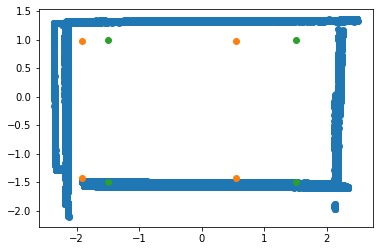

In [58]:
plt.scatter(x, y)
plt.scatter([rect[0], rect[0], rect[1], rect[1]], [rect[2], rect[3], rect[2], rect[3]])
plt.scatter([bbox[0], bbox[0], bbox[1], bbox[1]], [bbox[2], bbox[3], bbox[2], bbox[3]])